In [252]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import torch

In [253]:
from dataclasses import dataclass
import torch.nn as nn

def generate_spheres(npoints):
    harmonic_cfs = [[0, 0], [1, 1], [0, 1], [-1, 1], [2, 2], [1, 2], [0,2], [-1, 2], [-2, 2]]

    phi = np.linspace(0, np.pi, npoints)
    theta = np.linspace(0, 2*np.pi, npoints)
    phi, theta = np.meshgrid(phi, theta)
    spheres = torch.empty((9, npoints, npoints))

    for i, [m, l] in enumerate(harmonic_cfs):
        spheres[i, :, :] = torch.tensor(sph_harm(m, l, theta, phi).real)
    return spheres

def generate_sphere_coords(npoints):
    phi = np.linspace(0, np.pi, npoints)
    theta = np.linspace(0, 2*np.pi, npoints)
    phi, theta = np.meshgrid(phi, theta)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return x, y, z

@dataclass
class HarmonicSpheres:
    spheres = generate_spheres(100)
    x, y, z = generate_sphere_coords(100)

@dataclass
class Plenoxel:
    npoints = 100

    harmonics = HarmonicSpheres()
    weights: torch.Tensor = torch.rand((3, 9))

    def __post_init__(self):
        self.weights = torch.rand((3, 9))

    def get_total(self):
        spheres = self.harmonics.spheres
        weights = self.weights

        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (weights @ spheres.view((9, self.npoints**2))).T.view(self.npoints, self.npoints, 3)
        res = res.clamp(min=0, max=1)
        return res

    def get_cartesian(self):
        return self.harmonics.x, self.harmonics.y, self.harmonics.z

    # Compare sphere
    def __sub__(self, other):

        npoints = self.npoints
        myfft = torch.fft.fft(self.get_total().view(npoints**2, 4)[:, :3], dim = 1)
        otherfft = torch.fft.fft(other.get_total().view(100*100, 4)[:, :3], dim = 1)

        return abs((myfft - otherfft).mean(dim=(0, 1)))

In [254]:
# input: point on the sphere (theta, phi)
# output: color (rgba)

import torch.nn as nn

class SphereNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.plenoxel = Plenoxel()
        self.weights = nn.Parameter(self.plenoxel.weights, requires_grad=True)
        self.npoints = self.plenoxel.npoints

    def forward(self):
        spheres = self.plenoxel.harmonics.spheres
        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (self.weights @ spheres.view((9, self.npoints*self.npoints))).T.view(self.npoints, self.npoints, 3)
        
        res = res.clamp(min=0, max=1)
        return res

In [255]:
def plot_spheres(spheres : list[Plenoxel], titles: list[str]):
    x,y,z = spheres[0].get_cartesian()
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title(title1)
    ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=sphere1.get_total().numpy(), shade=False)
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title(title2)
    ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=sphere2.get_total().numpy(), shade=False)
    # Turn off the axis planes
    ax.set_axis_off()
    ax2.set_axis_off()
    plt.show()


In [256]:
import torch.optim as optim
from tqdm import tqdm

plenoxel = Plenoxel()
plenoxel.weights[0, :] = torch.tensor([1, 0, 1, 0, 0, 0, 0, 0, 0])
plenoxel.weights[1, :] = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0])
plenoxel.weights[2, :] = torch.tensor([0, 0, 1, 0, 0, 0, 1, 0, 0])

def train(target):

    model = SphereNet()

    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.3)
    epochs = 3000

    loss = 0
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()

        out = model()
        loss = loss_fn(out, target)

        loss.backward()
        optimizer.step()

    print(f"Finished training with final loss {loss.item()}")
    return model

target = plenoxel.get_total()
model = train(target)


100%|██████████| 3000/3000 [00:01<00:00, 2039.03it/s]

Finished training with final loss 2.2421898393076845e-05


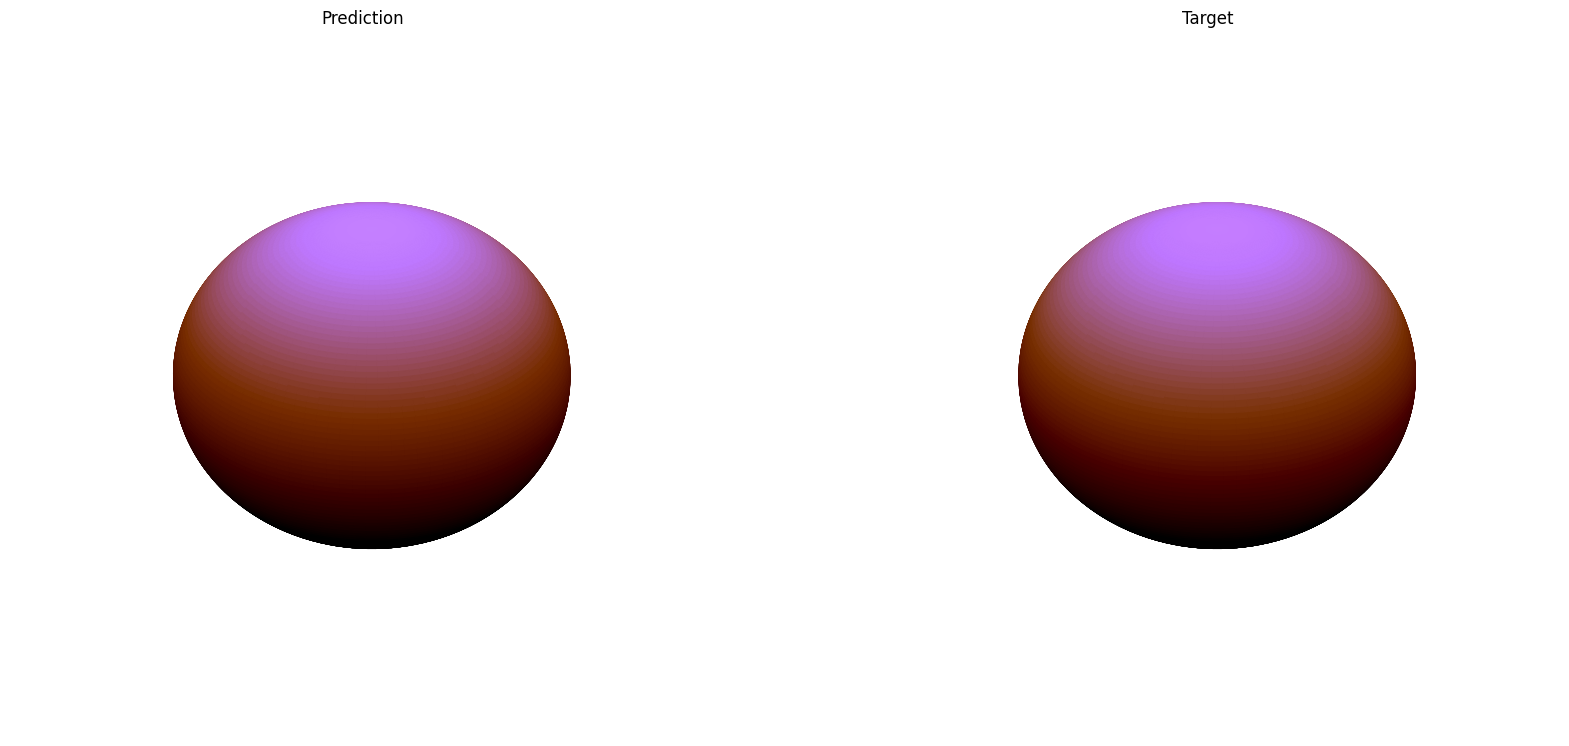

In [257]:
plot_spheres(model.plenoxel, plenoxel, "Prediction", "Target")

# Equal harmonics, different orientation

This problem could be solved by calculating rotation-invariant properties of every plenoxel after the initial training phase. (Basically 'resetting' their orientation).

The following part is a bit messy, but I hope you get the point. In the end, I compare the frequency domains of the sampled colors of similar and dissimilar plenoxels. Using this, we can compare plenoxels with different orientations!

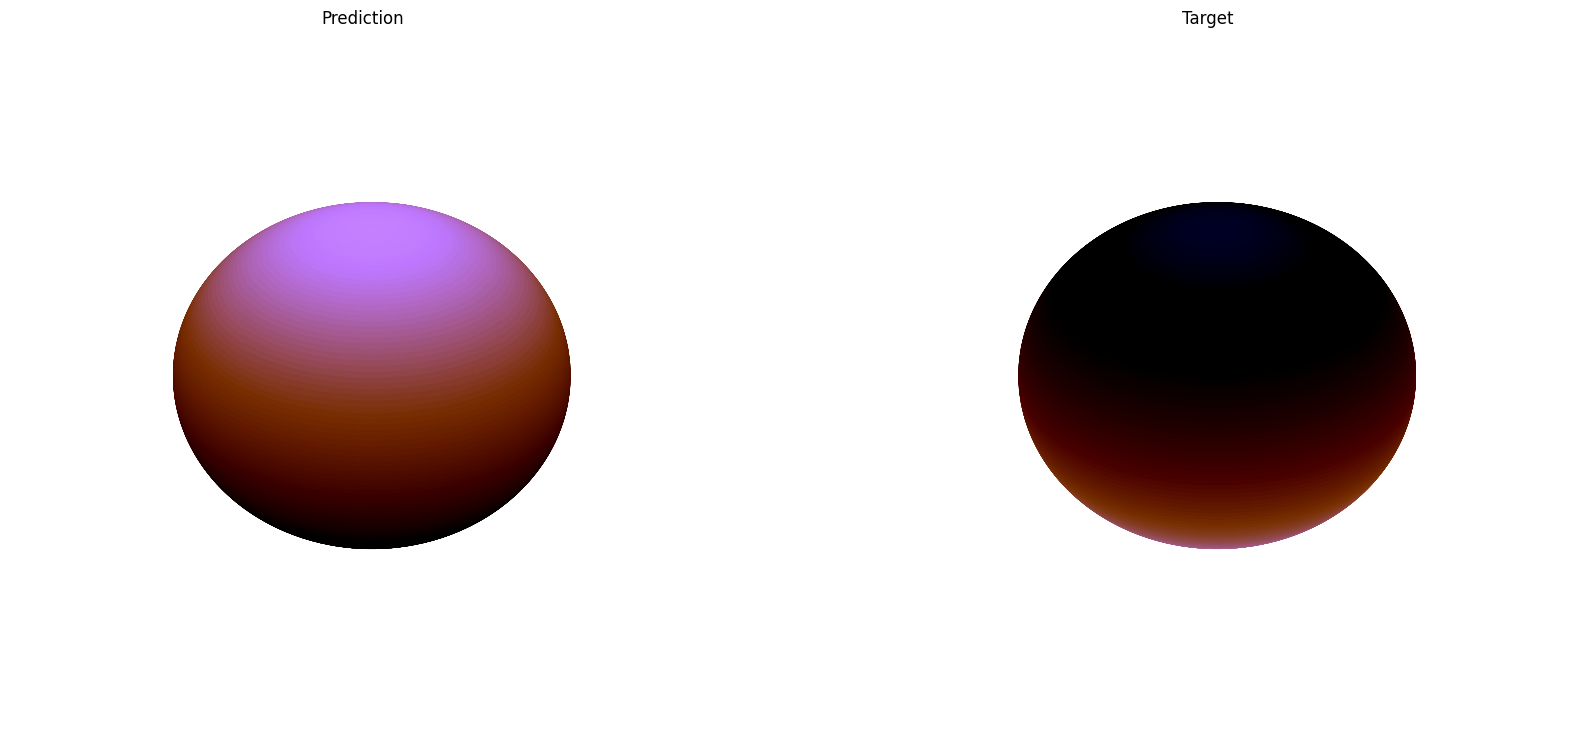

In [258]:
#original_coords = np.array([x,y,z]).reshape(3, 100*100)
target = plenoxel.get_total()
target = torch.flip(target.view(100*100, 4), dims=[0]).view(100,100,4)

x,y,z = plenoxel.get_cartesian()

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=model.plenoxel.get_total().numpy(), shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=target.numpy(), shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

In [259]:
# Can we learn rcoords?
model = train(target)

100%|██████████| 3000/3000 [00:01<00:00, 1912.85it/s]

Finished training with final loss 1.5911196896922775e-05


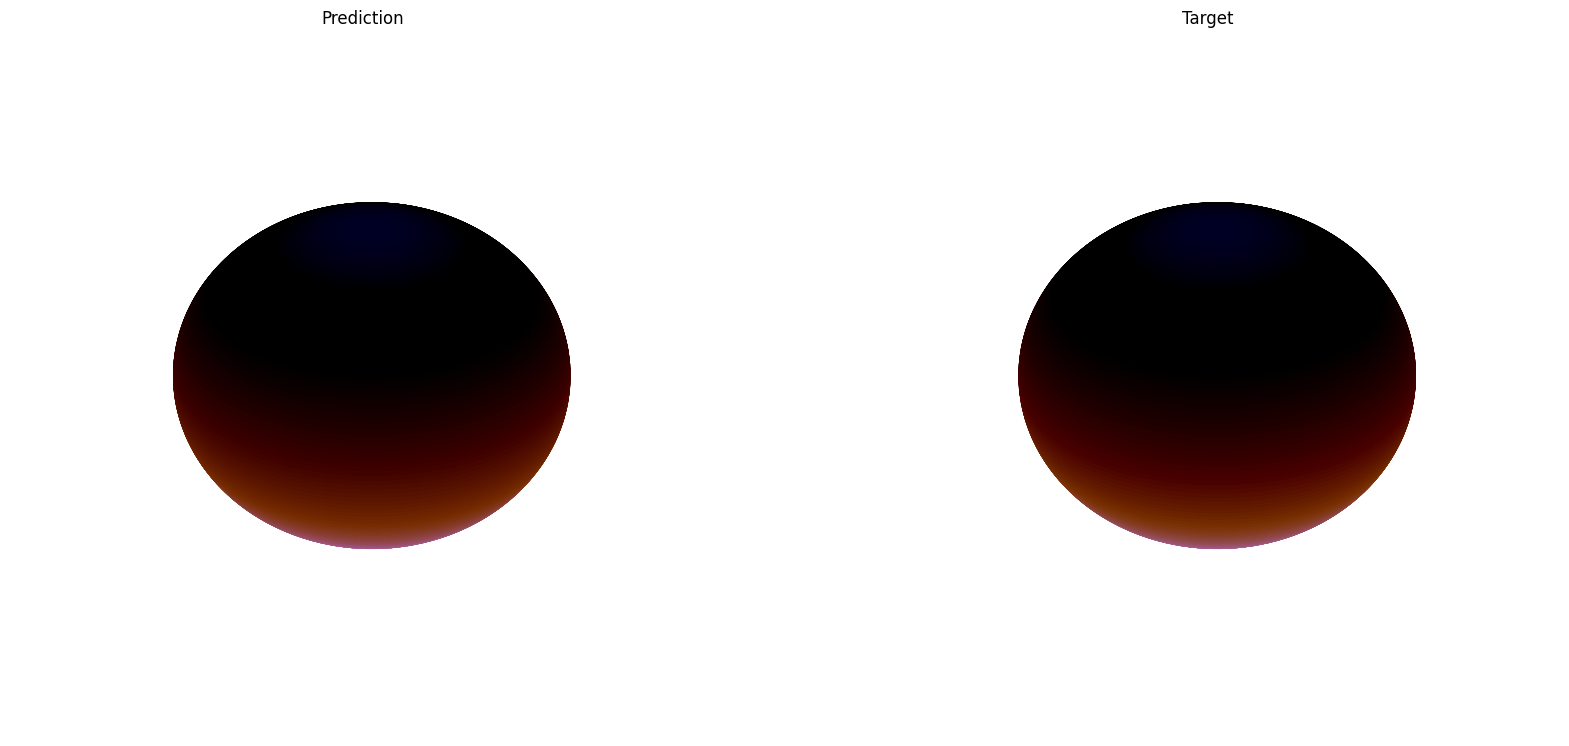

tensor([[ 9.9800e-01,  3.5000e-01, -1.0030e+00,  3.5000e-01,  2.0000e-02,
          5.9100e-01, -2.0000e-03,  5.9100e-01, -2.0000e-02],
        [ 2.5600e-01,  4.6200e-01, -6.9800e-01,  4.6100e-01,  1.7200e-01,
          4.9800e-01,  1.3500e-01,  4.9700e-01, -1.7200e-01],
        [ 2.2000e-02,  3.3100e-01, -9.9300e-01,  3.2900e-01, -1.0000e-03,
          5.6100e-01,  9.8500e-01,  5.6000e-01,  2.0000e-03]])
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0.]])


In [260]:
predcolors = model.plenoxel.get_total().numpy()
targcolors = target.numpy()
x,y,z = plenoxel.get_cartesian()


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

print((model.plenoxel.weights *1000).round()/1000)
print(plenoxel.weights)

In [261]:

# Note that two same spheres, rotated in a different direction, should have the
# same frequency domain.
randomsphere = Plenoxel()
whitesphere = Plenoxel()
# This is the representation of a pure white sphere.
whitesphere.weights = torch.tensor([[ 3.5768,  0.7600,  0.0081,  0.7588,  0.1288,  0.5222,  0.0280,  0.5151,
         -0.1284],
        [ 3.5736,  0.3626,  0.0148,  0.3650, -0.4068,  0.7502,  0.0237,  0.7568,
          0.4072],
        [ 3.5731,  0.2528,  0.0106,  0.2553, -0.1333,  0.5424,  0.0236,  0.5521,
          0.1341]])
blacksphere = Plenoxel()

# Pure black sphere
blacksphere.weights = torch.zeros((3, 9))

# See the implementation of harmonical sphere subtraction 
randomdiff = model.plenoxel - randomsphere
diff = model.plenoxel - plenoxel
diffwhite = model.plenoxel - whitesphere
diffblack = model.plenoxel - blacksphere
diff3 = whitesphere - blacksphere

print(f"Prediction vs Random sphere (should be between 0 and 1): {randomdiff}")
print(f"Similar spheres (should be ~0): {diff}")
print(f"Dissimilar spheres (distance to white): {diffwhite}")
print(f"Dissimilar spheres (distance to black): {diffblack}")
print(f"Sum of distance between black and white (should be ~1): {diffwhite + diffblack}")
print(f"Opposite spheres (should be ~1): {diff3}")

Prediction vs Random sphere (should be between 0 and 1): 0.0037989302072674036
Similar spheres (should be ~0): 4.672686191042885e-05
Dissimilar spheres (distance to white): 0.6761265993118286
Dissimilar spheres (distance to black): 0.3238699436187744
Sum of distance between black and white (should be ~1): 0.999996542930603
Opposite spheres (should be ~1): 0.999996542930603


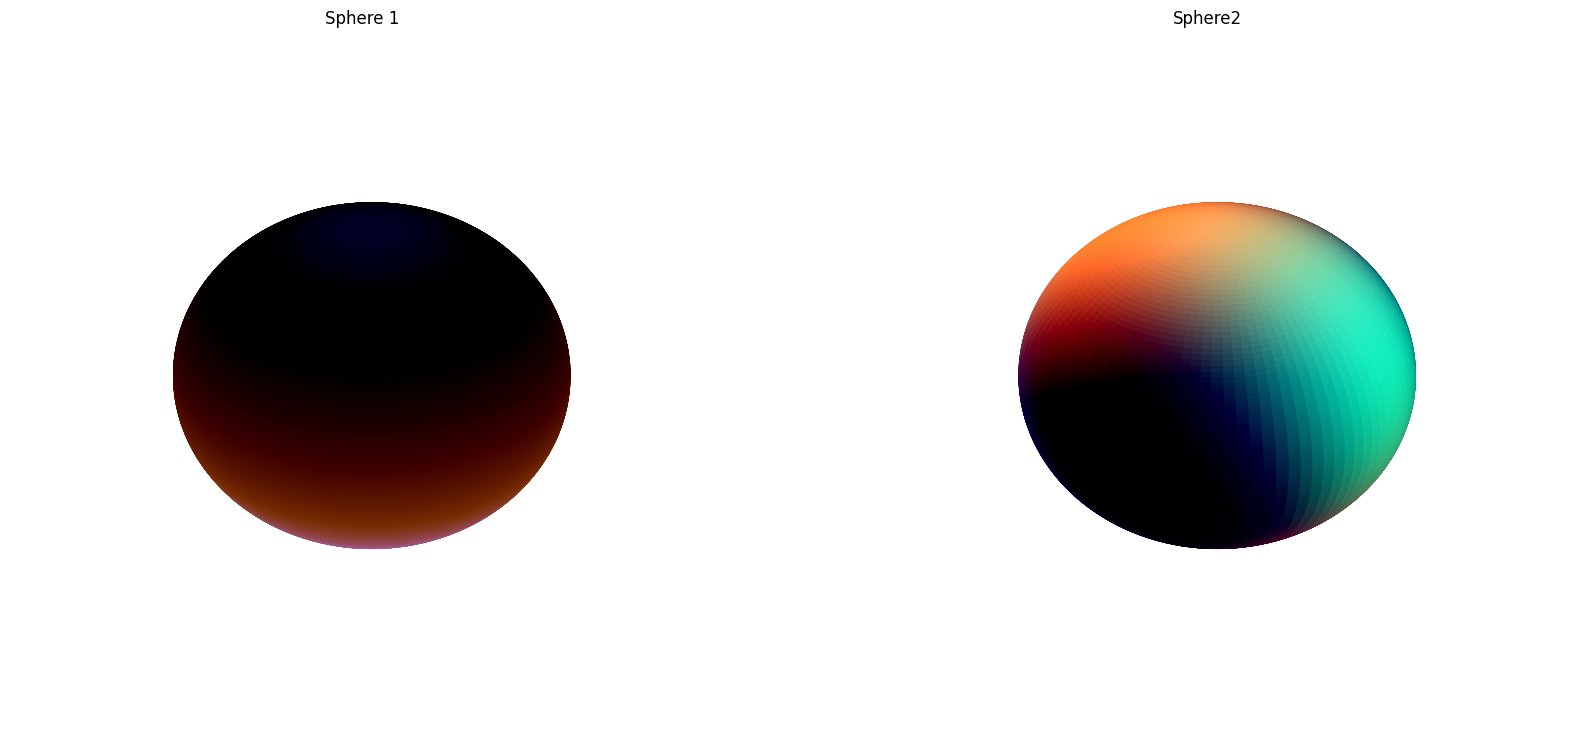

In [263]:
plot_spheres(model.plenoxel, randomsphere)